# 3.8 Sensitivity analysis

In this Notebook we are going to load the Disease model, execute it with different parameter values and test the impact on different parameters in different outputs.

- To load and run the Vensim model we use PySD library, please check the following tutorial before continuing: https://pysd.readthedocs.io/en/master/basic_usage.html#
- Model run's output are Pandas Data Frames, please refer to the Pandas documentation if you need additional insights and supported data operations: https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html#user-guide. 
There is also a 10min tutorial available that might be of your interest: https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
- We implemented the plots using matplotlib, if you need additional information please refer to the following documentation: https://matplotlib.org/stable/contents.html
- For calculating sensitivity indices we used SALib. A basic tutorial can be found here: https://salib.readthedocs.io/en/latest/ 

In [ ]:
# %pip install pysd==3.7.1 -q
# %pip install netCDF4==1.6.1 -q
# %pip install SALib==1.4.5 -q
# %pip install pysd

In [1]:
import warnings
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysd 
from SALib.sample import saltelli
from SALib.analyze import sobol

In [12]:
# load the model using PySD
# make sure the model file is in the same folder as the notebook
model = pysd.read_vensim(r'SFD_Group.mdl')

In [13]:
# run the model
model_output = model.run()
model_output.head(5)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Marriage rate,Delay for societal,Societal factor,Population,Delay for recovery,Divorce,...,Economic factor,Unmarried,K,Marriage,Married,Recovery rate,Divorce rate,Education,W eco,W soc
0.000,60,0,0.125,0.125,0.117999,0.5,0.606669,330000000.0,3,3.183599e+07,...,0.53333,4.700000e+07,1,5.545962e+06,1.400000e+08,0.3,0.227400,0.9,0.33,0.33
0.125,60,0,0.125,0.125,0.117999,0.5,0.606669,330000000.0,3,3.108870e+07,...,0.53333,5.166925e+07,1,6.096930e+06,1.367137e+08,0.3,0.227400,0.9,0.33,0.33
0.250,60,0,0.125,0.125,0.118074,0.5,0.606419,330000000.0,3,3.037463e+07,...,0.53333,5.626964e+07,1,6.643994e+06,1.335898e+08,0.3,0.227372,0.9,0.33,0.33
0.375,60,0,0.125,0.125,0.118211,0.5,0.605964,330000000.0,3,2.969363e+07,...,0.53333,6.079948e+07,1,7.187148e+06,1.306234e+08,0.3,0.227322,0.9,0.33,0.33
0.500,60,0,0.125,0.125,0.118398,0.5,0.605340,330000000.0,3,2.904533e+07,...,0.53333,6.525705e+07,1,7.726305e+06,1.278101e+08,0.3,0.227254,0.9,0.33,0.33


In [14]:
# list variables and parameters in the model
list(model_output)

['FINAL TIME',
 'INITIAL TIME',
 'SAVEPER',
 'TIME STEP',
 'Marriage rate',
 'Delay for societal',
 'Societal factor',
 'Population',
 'Delay for recovery',
 'Divorce',
 'Recovery',
 'Divorced',
 'Economic factor',
 'Unmarried',
 'K',
 'Marriage',
 'Married',
 'Recovery rate',
 'Divorce rate',
 'Education',
 'W eco',
 'W soc']

## Calculation of sensitivity indices

In [75]:
#Day 10

observable = 'Divorce'
parameter1 = 'W eco'
parameter2 = 'W soc'
parameter3 = 'K'
parameter4 = 'Recovery rate'
parameter5 =  'Delay for societal'
timetoobserve = 27


parameter1_vals = []
parameter2_vals = []
parameter3_vals = []
parameter4_vals = []
parameter5_vals = []
observable_vals = []

# loop over different values of total W eco
for param1_val in np.range(0, 1, 0.01):

    # loop over different values of W soc
    for param2_val in np.range(0, 1, 0.01):

        # loop over different values of K
            for param3_val in np.range(0, 1, 0.01):
                # loop over different values of Recovery rate
                for param4_val in np.range(0, 1, 0.01):
                    # loop over different values of delay of societal
                    for param5_val in np.range(0., 10, 0.5):

                        # multiple repetitions for each parameter combination
                        for i in np.arange(0, 1, 1):

                            # run the model with the current parameter combination
                            # the following two lines hide warnings which we don't want to see
                            with warnings.catch_warnings():
                                warnings.filterwarnings('ignore')
                                result = model.run(params={parameter1: param1_val,
                                                        parameter2: param2_val,
                                                        parameter3: param3_val,
                                                        parameter4: param4_val,
                                                        parameter5:param5_val},
                                                return_timestamps=[timetoobserve],
                                                return_columns=[observable])

                            # store results
                            parameter1_vals.append(param1_val)
                            parameter2_vals.append(param2_val)
                            parameter3_vals.append(param3_val)
                            parameter4_vals.append(param4_val)
                            parameter5_vals.append(param5_val)
                            obeservable_val = result.loc[timetoobserve, observable]
                            observable_vals.append(obeservable_val)
                            print("Calculated with parameters: ",param1_val,param2_val,param3_val,param4_val,"and: ",param5_val,". Got observable=",obeservable_val)#


# collect results into a DataFrame
output10 = pd.DataFrame({parameter1: parameter1_vals,
                       parameter2: parameter2_vals,
                       parameter3: parameter3_vals,
                       parameter4: parameter4_vals,
                       parameter5: parameter5_vals,
                       observable: observable_vals})

Calculated with parameters:  0 0.0 and:  0.0 . Got observable= 0.0
Calculated with parameters:  0 0.0 and:  100000000.0 . Got observable= 3468584.2816497935
Calculated with parameters:  0 0.0 and:  200000000.0 . Got observable= 6937168.563299587
Calculated with parameters:  0 0.0 and:  300000000.0 . Got observable= 10405752.844949396
Calculated with parameters:  0 0.0 and:  400000000.0 . Got observable= 13874337.126599174
Calculated with parameters:  0 0.0 and:  500000000.0 . Got observable= 17342921.408248987
Calculated with parameters:  0 0.0 and:  600000000.0 . Got observable= 20811505.689898793
Calculated with parameters:  0 0.0 and:  700000000.0 . Got observable= 24280089.9715486
Calculated with parameters:  0 0.0 and:  800000000.0 . Got observable= 27748674.253198348
Calculated with parameters:  0 0.0 and:  900000000.0 . Got observable= 31217258.53484819
Calculated with parameters:  0 0.1 and:  0.0 . Got observable= 0.0
Calculated with parameters:  0 0.1 and:  100000000.0 . Got o

In [78]:
#Day 90

observable = 'Bacteria'
parameter1 = 'Initial Nutrient concentration'
parameter2 = 'Replenishment rate'
parameter3 = 'Initial Bacteria'
timetoobserve = 90


parameter1_vals = []
parameter2_vals = []
parameter3_vals = []
observable_vals = []

# loop over different values of total initial nutrients
for param1_val in np.arange(0, 11, 1):

    # loop over different values of replenishment rate
    for param2_val in np.arange(0., 1.1, 0.1):

        # loop over different values of maimum
            for param3_val in np.arange(0., 1000000000, 100000000):

                # multiple repetitions for each parameter combination
                for i in np.arange(0, 1, 1):

                    # run the model with the current parameter combination
                    # the following two lines hide warnings which we don't want to see
                    with warnings.catch_warnings():
                        warnings.filterwarnings('ignore')
                        result = model.run(params={parameter1: param1_val,
                                                parameter2: param2_val,
                                                parameter3:param3_val},
                                        return_timestamps=[timetoobserve],
                                        return_columns=[observable])

                    # store results
                    parameter1_vals.append(param1_val)
                    parameter2_vals.append(param2_val)
                    parameter3_vals.append(param3_val)
                    obeservable_val = result.loc[timetoobserve, observable]
                    observable_vals.append(obeservable_val)
                    print("Calculated with parameters: ",param1_val,param2_val,"and: ",param3_val,". Got observable=",obeservable_val)#


# collect results into a DataFrame
output90 = pd.DataFrame({parameter1: parameter1_vals,
                       parameter2: parameter2_vals,
                       parameter3: parameter3_vals,
                       observable: observable_vals})

Calculated with parameters:  0 0.0 and:  0.0 . Got observable= 0.0
Calculated with parameters:  0 0.0 and:  100000000.0 . Got observable= 7.267252756439436e-06
Calculated with parameters:  0 0.0 and:  200000000.0 . Got observable= 1.4534505512878871e-05
Calculated with parameters:  0 0.0 and:  300000000.0 . Got observable= 2.1801758269318348e-05
Calculated with parameters:  0 0.0 and:  400000000.0 . Got observable= 2.9069011025757742e-05
Calculated with parameters:  0 0.0 and:  500000000.0 . Got observable= 3.633626378219734e-05
Calculated with parameters:  0 0.0 and:  600000000.0 . Got observable= 4.3603516538636695e-05
Calculated with parameters:  0 0.0 and:  700000000.0 . Got observable= 5.087076929507634e-05
Calculated with parameters:  0 0.0 and:  800000000.0 . Got observable= 5.8138022051515485e-05
Calculated with parameters:  0 0.0 and:  900000000.0 . Got observable= 6.540527480795527e-05
Calculated with parameters:  0 0.1 and:  0.0 . Got observable= 0.0
Calculated with paramete

In [76]:
output10

,Initial Nutrient concentration,Replenishment rate,Initial Bacteria,Bacteria
0,0,0.0,0.0,0.000000e+00
1,0,0.0,100000000.0,3.468584e+06
2,0,0.0,200000000.0,6.937169e+06
3,0,0.0,300000000.0,1.040575e+07
4,0,0.0,400000000.0,1.387434e+07
...,...,...,...,...
1205,10,1.0,500000000.0,2.260031e+08
1206,10,1.0,600000000.0,2.183902e+08
1207,10,1.0,700000000.0,2.588790e+08
1208,10,1.0,800000000.0,2.541074e+08


In [79]:

output90

,Initial Nutrient concentration,Replenishment rate,Initial Bacteria,Bacteria
0,0,0.0,0.0,0.000000e+00
1,0,0.0,100000000.0,7.267253e-06
2,0,0.0,200000000.0,1.453451e-05
3,0,0.0,300000000.0,2.180176e-05
4,0,0.0,400000000.0,2.906901e-05
...,...,...,...,...
1205,10,1.0,500000000.0,4.151201e+07
1206,10,1.0,600000000.0,4.106995e+07
1207,10,1.0,700000000.0,3.554671e+07
1208,10,1.0,800000000.0,3.953004e+07


In [77]:
# variance of the observable across all parameter combinations
observable_var = output10.var(ddof=0)[observable]
print(f'Total variance on day 10 in {observable}: {observable_var:.4f}')

# sensitivity index for parameter 1
param1_ind = output10.groupby(parameter1).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter1} on day 10 is {param1_ind:.4f}')

# sensitivity index for parameter 2
param2_ind = output10.groupby(parameter2).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter2} on day 10 is {param2_ind:.4f}')


# sensitivity index for parameter 3
param3_ind = output10.groupby(parameter3).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter3} on day 10 is {param3_ind:.4f}')

Total variance on day 10 in Bacteria: 6502208417194082.0000
An estimate of the first-order sensitivity index of Initial Nutrient concentration on day 10 is 0.0697
An estimate of the first-order sensitivity index of Replenishment rate on day 10 is 0.0019
An estimate of the first-order sensitivity index of Initial Bacteria on day 10 is 0.8986


In [80]:
# variance of the observable across all parameter combinations
observable_var = output90.var(ddof=0)[observable]
print(f'Total variance on day 90 in {observable}: {observable_var:.4f}')

# sensitivity index for parameter 1
param1_ind = output90.groupby(parameter1).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter1} on day 90 is {param1_ind:.4f}')

# sensitivity index for parameter 2
param2_ind = output90.groupby(parameter2).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter2} on day 90 is {param2_ind:.4f}')


# sensitivity index for parameter 3
param3_ind = output90.groupby(parameter3).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter3} on day 90 is {param3_ind:.4f}')

Total variance on day 90 in Bacteria: 153229045890175.4375
An estimate of the first-order sensitivity index of Initial Nutrient concentration on day 90 is 0.0024
An estimate of the first-order sensitivity index of Replenishment rate on day 90 is 0.6626
An estimate of the first-order sensitivity index of Initial Bacteria on day 90 is 0.2452


## Calculation of sensitivity indices using SALib

In [81]:
# define problem for determining the sensitivity indices using SALib
problem = {
    'num_vars': 3,
    'names': ['Initial Nutrient concentration', 'Replenishment rate','Initial Bacteria'], #,'Maximum'
    'bounds': [[0, 10],
               [0, 1],[0, 1000000000]]#
}

# calculate sample points used for sensitivity analysis
param_values = saltelli.sample(problem, 128, calc_second_order=False)

In [82]:
# array for observable values - Day 10
Y = np.zeros([param_values.shape[0]])
timetoobserve=10
# loop through all parameter combinations in the sample
for i, X in enumerate(param_values):
    param1_val, param2_val, param3_val = X #, param3_val 

    # store observable value at this parameter combination
    # again, we want to ignore warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        Y[i] = model.run(params={parameter1: param1_val, parameter2: param2_val,parameter3: param3_val}, #,parameter3: param3_val
                         return_timestamps=[timetoobserve],
                         return_columns=[observable]).loc[timetoobserve, observable]

In [85]:
# array for observable values - Day 90
Y2 = np.zeros([param_values.shape[0]])
timetoobserve=90
# loop through all parameter combinations in the sample
for i, X in enumerate(param_values):
    param1_val, param2_val, param3_val = X #, param3_val 

    # store observable value at this parameter combination
    # again, we want to ignore warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        Y2[i] = model.run(params={parameter1: param1_val, parameter2: param2_val,parameter3: param3_val}, #,parameter3: param3_val
                         return_timestamps=[timetoobserve],
                         return_columns=[observable]).loc[timetoobserve, observable]

In [83]:
# perform calculation of sensitivity indices
Si = sobol.analyze(problem, Y, calc_second_order=False, print_to_console=True)

                                      ST   ST_conf
Initial Nutrient concentration  0.023643  0.010013
Replenishment rate              0.008145  0.002800
Initial Bacteria                0.998204  0.169935
                                      S1   S1_conf
Initial Nutrient concentration  0.015550  0.036528
Replenishment rate             -0.005379  0.023715
Initial Bacteria                0.960157  0.231174


In [86]:
# perform calculation of sensitivity indices
Si2 = sobol.analyze(problem, Y2, calc_second_order=False, print_to_console=True)

                                      ST   ST_conf
Initial Nutrient concentration  0.025532  0.008597
Replenishment rate              0.956359  0.146724
Initial Bacteria                0.053667  0.014916
                                      S1   S1_conf
Initial Nutrient concentration -0.008222  0.036018
Replenishment rate              0.922309  0.170927
Initial Bacteria                0.012269  0.062997


array([<Axes: >, <Axes: >], dtype=object)

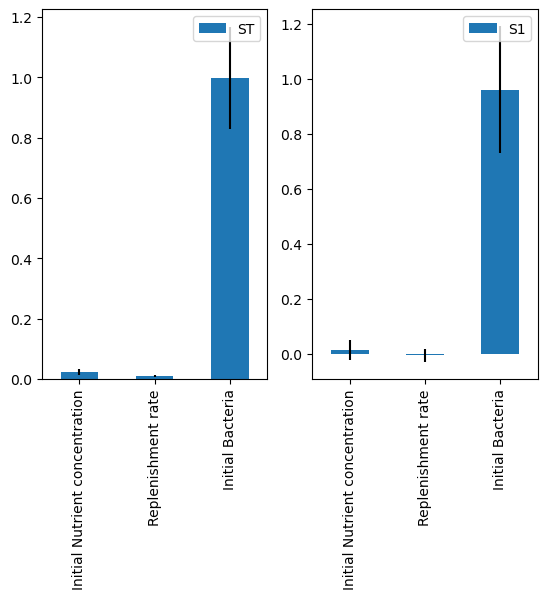

In [84]:
Si.plot()

array([<Axes: >, <Axes: >], dtype=object)

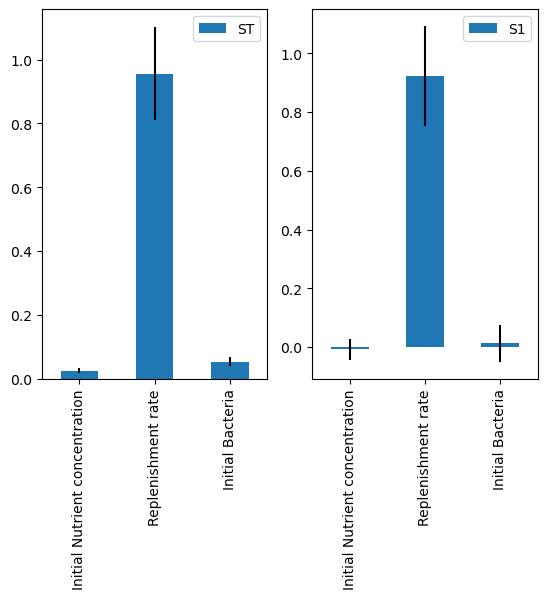

In [87]:
Si2.plot()